In [1]:
import random
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
from scipy.stats import poisson, norm

In [2]:
# Define the player class
class Player(Agent):
    def __init__(self, unique_id, model, pm, delay, probability):
        super().__init__(unique_id, model)
        self.pm = pm  # Profit margin
        self.delay = delay
        self.probability = probability
        self.bid = 0
        self.private_signal_value = 0
        self.aggregated_signal = 0
        self.bid_queue = deque(maxlen=(self.delay + self.model.global_delay))

    def update_aggregated_signal(self):
        self.aggregated_signal = self.model.public_signal_value + self.private_signal_value

    def step(self):
        self.update_aggregated_signal()
        # Logic for making a bid, specific to each strategy subclass

    def advance(self):
        if len(self.bid_queue) == self.delay + self.model.global_delay:
            self.model.current_bids.append(self.bid_queue.popleft())
            self.model.bid_agents.append(self.unique_id)

In [3]:
class PlayerWithNaiveStrategy(Player):
    def step(self):
        super().step()
        if self.aggregated_signal > self.pm:
            self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [4]:
class PlayerWithAdaptiveStrategy(Player):
    def step(self):
        super().step()
        delta = 0.0001  # Small increment to outbid the highest current bid
        if self.aggregated_signal > self.pm and len(self.model.max_bids) > 0:
            if self.aggregated_signal - self.pm > self.model.max_bids[-1] + delta:
                self.bid = self.model.max_bids[-1] + delta
            elif self.aggregated_signal - self.pm <= self.model.max_bids[-1] + delta:
                self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [5]:
class PlayerWithLastMinuteStrategy(Player):
    def __init__(self, unique_id, model, pm, delay, probability, time_estimate, time_reveal_epsilon):
        super().__init__(unique_id, model, pm, delay, probability)
        self.time_estimate = time_estimate
        self.time_reveal_epsilon = time_reveal_epsilon

    def step(self):
        super().step()
        time_reveal = self.time_estimate - self.time_reveal_epsilon - self.model.global_delay - self.delay
        if self.model.schedule.time >= time_reveal:
            if self.aggregated_signal > self.pm:
                self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [6]:
class PlayerWithStealthStrategy(Player):
    def __init__(self, unique_id, model, pm, delay, probability, time_estimate, time_reveal_epsilon):
        super().__init__(unique_id, model, pm, delay, probability)
        self.time_estimate = time_estimate
        self.time_reveal_epsilon = time_reveal_epsilon

    def step(self):
        super().step()
        time_reveal = self.time_estimate - self.time_reveal_epsilon - self.model.global_delay - self.delay
        if self.model.schedule.time < time_reveal and self.model.public_signal_value > self.pm:
            self.bid = self.model.public_signal_value - self.pm
        elif self.model.schedule.time >= time_reveal and self.aggregated_signal > self.pm:
            self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [7]:
class PlayerWithBluffStrategy(Player):
    def __init__(self, unique_id, model, pm, delay, probability, time_estimate, time_reveal_epsilon, bluff_value):
        super().__init__(unique_id, model, pm, delay, probability)
        self.time_estimate = time_estimate
        self.time_reveal_epsilon = time_reveal_epsilon
        self.bluff_value = bluff_value

    def step(self):
        super().step()
        time_reveal = self.time_estimate - self.time_reveal_epsilon - self.model.global_delay - self.delay
        if self.model.schedule.time < time_reveal:
            self.bid = self.bluff_value
        elif self.aggregated_signal > self.pm:
            self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [8]:
def get_current_bids(model):
    return model.show_current_bids

def get_bid_agents(model):
    return model.show_bid_agents

def get_public_signal(model):
    return model.public_signal_value

def get_private_signal_max(model):
    return model.private_signal_max

def get_aggregated_signal_max(model):
    return model.aggregated_signal_max

In [9]:
class Auction(Model):
    def __init__(self, N, A, L, S, B, rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd,
                 T_mean, T_sd, delay,):
        super().__init__()
        self.num_agents = {'Naive': N, 'Adaptive': A, 'LastMinute': L, 'Stealth': S, 'Bluff': B}
        self.global_delay = delay
        self.T = norm.rvs(loc=T_mean, scale=T_sd)
        self.schedule = SimultaneousActivation(self)
        self.setup_agents()
        self.setup_signals(rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd)
        self.setup_bids()
        self.setup_winner()
        self.datacollector = DataCollector(
            model_reporters={
                "Current Bids" : get_current_bids,
                "Agents" : get_bid_agents,
                "Public Signal" : get_public_signal,
                "Private Signal Max" : get_private_signal_max,
                "Aggregated Signal Max" : get_aggregated_signal_max,
            },
            agent_reporters={"Bid" : "bid",
                             "Probability" : "probability",
                             }
        )


    def setup_agents(self):
        # Initialize agents with their strategies
        agent_id = 0
        for strategy, count in self.num_agents.items():
            for _ in range(count):
                pm = norm.rvs(loc=0.00659, scale=0.0001)
                delay = 1
                probability = np.random.uniform(0.8, 1.0)
                if strategy == 'Naive':
                    agent = PlayerWithNaiveStrategy(agent_id, self, pm, delay, probability)
                elif strategy == 'Adaptive':
                    agent = PlayerWithAdaptiveStrategy(agent_id, self, pm, delay, probability)
                elif strategy == 'LastMinute':
                    time_estimate = 1200
                    time_reveal_epsilon = 0
                    agent = PlayerWithLastMinuteStrategy(agent_id, self, pm, delay, probability, time_estimate,
                                                         time_reveal_epsilon)
                elif strategy == 'Stealth':
                    time_estimate = 1200
                    time_reveal_epsilon = 0
                    agent = PlayerWithStealthStrategy(agent_id, self, pm, delay, probability, time_estimate,
                                                      time_reveal_epsilon)
                elif strategy == 'Bluff':
                    time_estimate = 1200
                    time_reveal_epsilon = 0
                    bluff_value = 0.2
                    agent = PlayerWithBluffStrategy(agent_id, self, pm, delay, probability, time_estimate,
                                                  time_reveal_epsilon, bluff_value)
                self.schedule.add(agent)
                agent_id += 1

    def setup_signals(self, rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd):
        # Initialize signal parameters
        self.public_signal = 0
        self.public_signal_value = 0
        self.private_signal = 0
        self.private_signal_max = 0
        self.aggregated_signal_max = 0
        self.public_lambda = norm.rvs(loc=rate_public_mean, scale=rate_public_sd)
        self.private_lambda = norm.rvs(loc=rate_private_mean, scale=rate_private_sd)

    def setup_bids(self):
        self.max_bids = []
        self.current_bids = []
        self.bid_agents = []
        self.winning_agents = []
        self.show_current_bids = []
        self.show_bid_agents = []

    def setup_winner(self):
        self.winner_profit = 0
        self.winner_trueprofit = 0
        self.winner_aggregated_signal = 0
        self.winner_probability = 0
        self.auction_efficiency = 0

    def step(self):
        # Update public signal
        new_public_signal = poisson.rvs(mu=self.public_lambda)
        self.public_signal += new_public_signal

        for _ in range(new_public_signal) :
            signal_value = np.random.lognormal(mean=-11.66306, sigma=3.05450)
            # Add the value of the current public signal to the total value
            self.public_signal_value += signal_value

        # Update private signal
        new_private_signal = poisson.rvs(mu=self.private_lambda)
        self.private_signal += new_private_signal

        for _ in range(new_private_signal) :
            private_signal_value = np.random.lognormal(mean=-8.41975, sigma=1.95231)
            self.private_signal_max += private_signal_value
            for agent in self.schedule.agents :
                if random.random() < agent.probability :
                    agent.private_signal_value += private_signal_value

        self.aggregated_signal_max = self.public_signal_value + self.private_signal_max

        self.schedule.step()

        # select the winner of the step
        if self.current_bids :
            max_bid_value = max(bid for bid, _ in self.current_bids)
            # Get all bids that are equal to the maximum bid value
            max_bids = [(bid, agent_id) for bid, agent_id in zip(self.current_bids, self.bid_agents) if
                        bid[0] == max_bid_value]
            # Randomly select one of the maximum bids
            selected_bid, winner_id = random.choice(max_bids)
            self.max_bids.append(selected_bid[0])
            self.winning_agents.append(winner_id)
            self.winner_profit = selected_bid[1]-selected_bid[0]
            if self.aggregated_signal_max == 0:
                self.auction_efficiency = 0
            else:
                self.auction_efficiency = selected_bid[0]/self.aggregated_signal_max

            for agent in self.schedule.agents:
                if agent.unique_id == winner_id:
                    self.winner_aggregated_signal = selected_bid[1]
                    self.winner_probability = agent.probability


        self.show_current_bids = self.current_bids.copy()
        self.show_bid_agents = self.bid_agents.copy()

        self.current_bids.clear()
        self.bid_agents.clear()

        # Collect data at the end of the step
        self.datacollector.collect(self)

In [10]:
# Function to run the model and collect data
model = Auction(N=4, A=4, L=4, S=0, B=0, rate_public_mean=0.082, rate_public_sd=0.02, rate_private_mean=0.04, rate_private_sd=0.013, T_mean=12, T_sd=0, delay=1)
for i in range(int(model.T * 100)):
    model.step()

In [11]:
# Data Collection
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

In [12]:
# Print the simulation details
print(f"Public signal number: {model.public_signal}")
print(f"Public signal value: {model.public_signal_value}")
print(f"Private signal number: {model.private_signal}")
print(f"Auction time (seconds): {model.T}")
print(f"Auction time steps: {model.schedule.time}")
print("\n")
print(agent_data.loc[i, 'Probability'])
print("\n")
print(f"Winning Bid of Each Step: {model.max_bids}")
print(f"Winning Agent of Each Step: {model.winning_agents}")

Public signal number: 95
Public signal value: 0.0693410137427261
Private signal number: 62
Auction time (seconds): 12.0
Auction time steps: 1200


AgentID
0     0.828390
1     0.920496
2     0.904601
3     0.816017
4     0.980468
5     0.821440
6     0.842724
7     0.996073
8     0.834614
9     0.829257
10    0.828288
11    0.927247
Name: Probability, dtype: float64


Winning Bid of Each Step: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.041096946591542415, 0.041096946591542415, 0.04117963992336954, 0.04320664698093735, 0.04320664698093735, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04329389138799285, 0.04339389138799285, 0.04339389138799285, 0.043437552029408806, 0.04700895322351842, 0.04700895322351842, 0.04709164655534554, 0.04709164655534554, 0.04709164655534554, 0.047093096228

In [13]:
# Print table for each step
for time_step in range(int(model.T * 100)):
    current_bids_at_time_step = model_data.loc[time_step, 'Current Bids']
    bid_agents_at_time_step = model_data.loc[time_step, 'Agents']
    if current_bids_at_time_step :
        bids, aggregated_signals = zip(*current_bids_at_time_step)

        df = pd.DataFrame({
            'Bids' : bids,
            'Aggregated Signals' : aggregated_signals,
            'Agents' : bid_agents_at_time_step
        })
        print(f"Data for time step {time_step}:")
        print(df)
        print("\n")
    else :
        print(f"Data for time step {time_step}: Empty Dataframe. No bids recorded on the relay.\n")


Data for time step 0: Empty Dataframe. No bids recorded on the relay.

Data for time step 1:
    Bids  Aggregated Signals  Agents
0      0                   0       0
1      0                   0       1
2      0                   0       2
3      0                   0       3
4      0                   0       4
5      0                   0       5
6      0                   0       6
7      0                   0       7
8      0                   0       8
9      0                   0       9
10     0                   0      10
11     0                   0      11


Data for time step 2:
    Bids  Aggregated Signals  Agents
0      0            0.000108       0
1      0            0.000079       1
2      0            0.000108       2
3      0            0.000108       3
4      0            0.000108       4
5      0            0.000108       5
6      0            0.000108       6
7      0            0.000108       7
8      0            0.000108       8
9      0            0.000108    

In [14]:
print('Winning Agent ID: ' + str(model.winning_agents[-1:][0]))
print('Winning bid value: ' + str(model.max_bids[-1:][0]))
print(f"Winner Profit: {model.winner_profit}")
print(f"Winner Total Signal: {model.winner_aggregated_signal}")
print(f"Winner Probility: {model.winner_probability}")
print('Winning bid time: ' + str(time_step) + ' ms')
print(f"Auction Efficiency: {model.auction_efficiency}")

Winning Agent ID: 7
Winning bid value: 0.1821996293285147
Winner Profit: 0.006753893799743338
Winner Total Signal: 0.18895352312825803
Winner Probility: 0.996073335680926
Winning bid time: 1199 ms
Auction Efficiency: 0.9623629296515942


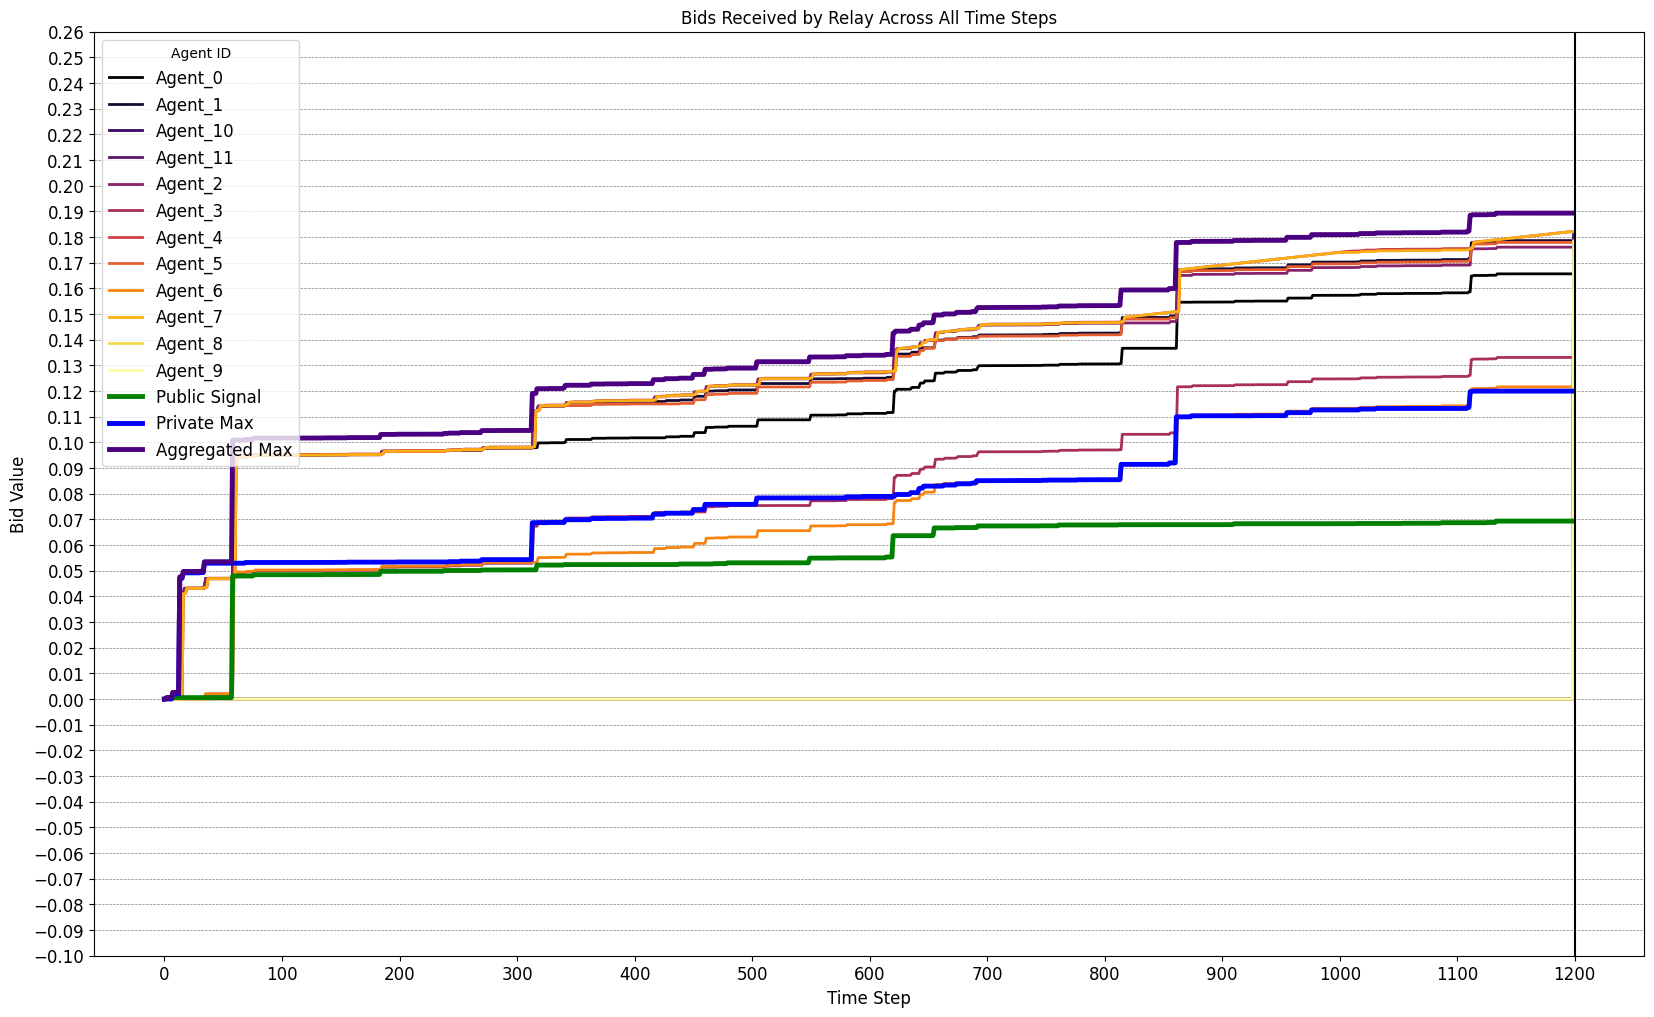

In [15]:
#Plotting
dfs = []
for i in range(len(model_data)):
    current_bids = model_data["Current Bids"].iloc[i]
    current_agents = model_data["Agents"].iloc[i]

    if current_bids:
        bids, aggregated_signals = zip(*current_bids)
    else:
        bids, aggregated_signals = [], []

    for agent, bid, signal in zip(current_agents, bids, aggregated_signals):
        dfs.append(pd.DataFrame({
            "Time Step": [i],
            "Agent ID": [f"Agent_{agent}"],
            "Bid": [bid],
            "Signal": [signal]
        }))

# Concatenate all DataFrames
all_bids = pd.concat(dfs)
public_signals = model_data["Public Signal"]
private_signal_max = model_data["Private Signal Max"]
aggregated_signal_max = model_data["Aggregated Signal Max"]
# Pivot the DataFrame to have time steps as index and agents' bids as columns
pivot_bids = all_bids.pivot(index="Time Step", columns="Agent ID", values="Bid")

# Plotting
plt.figure(figsize=(20, 12))
plt.gca().set_prop_cycle('color', plt.cm.inferno(np.linspace(0, 1, len(pivot_bids.columns))))

fontsize = 12
for column in pivot_bids.columns:
    plt.plot(pivot_bids.index, pivot_bids[column], label=column, linewidth=2)

# Adding other signals to the plot
plt.plot(public_signals.index, public_signals, label='Public Signal', linewidth=3.5, color='green')
plt.plot(private_signal_max.index, private_signal_max, label='Private Max', linewidth=3.5, color='blue')
plt.plot(aggregated_signal_max.index, aggregated_signal_max, label='Aggregated Max', linewidth=3.5, color='indigo')
# Rest of the plotting code remains the same
plt.xlabel('Time Step', fontsize=fontsize)
plt.ylabel('Bid Value', fontsize=fontsize)
plt.legend(title='Agent ID', fontsize=12)
plt.title('Bids Received by Relay Across All Time Steps', fontsize=fontsize)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.xticks(np.arange(0, 1300, 100), fontsize=fontsize)
plt.yticks(np.arange(-0.1, 0.27, 0.01), fontsize=fontsize)
plt.axvline(1200, color='k')

plt.show()